In [25]:
import numpy as np
import preprocess as pp

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# paths
infile = "../data/raw_activity.csv"

# hyperparameters
test_ratio = 0.3
batch_size = 32
learning_rate = 0.0001
epochs = 20

Training Data:


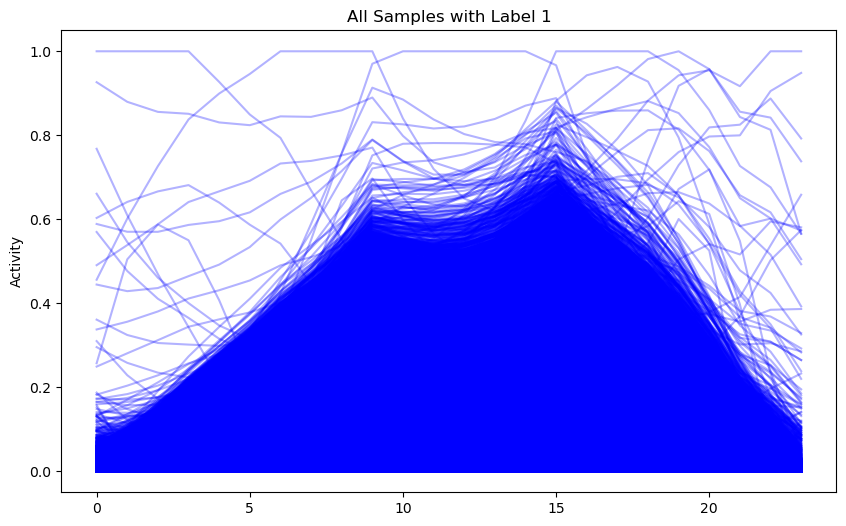

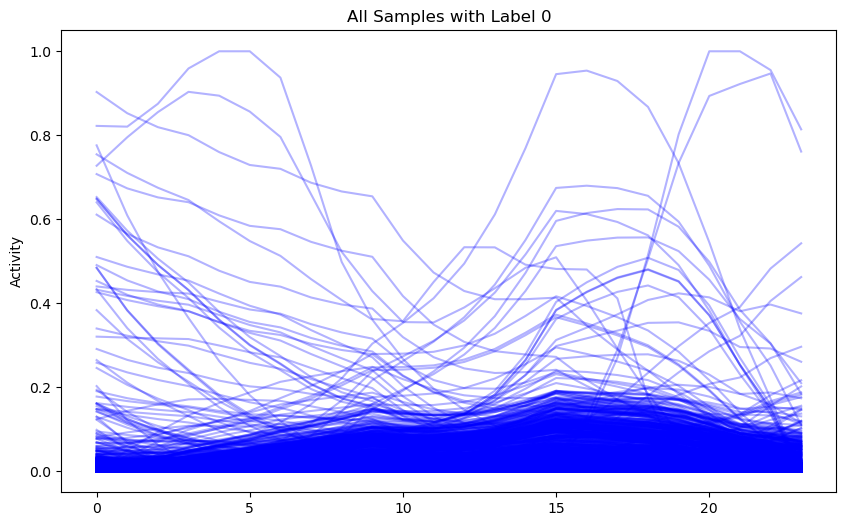

Test Data:


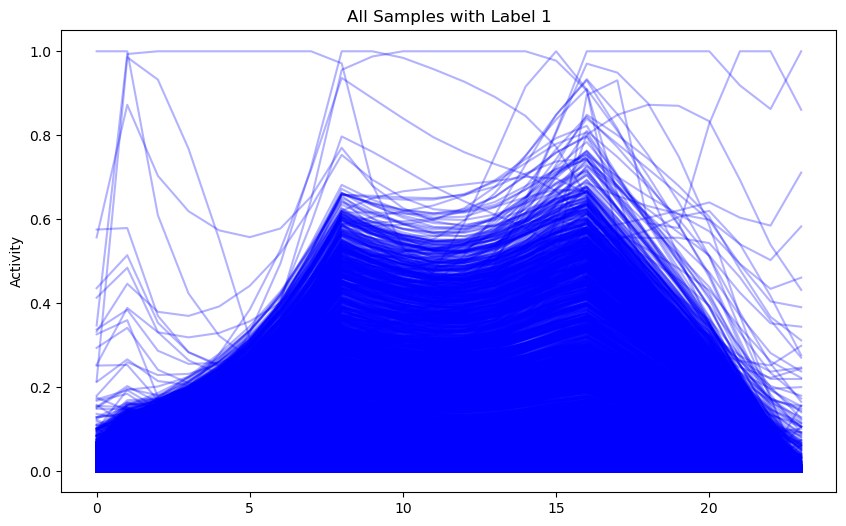

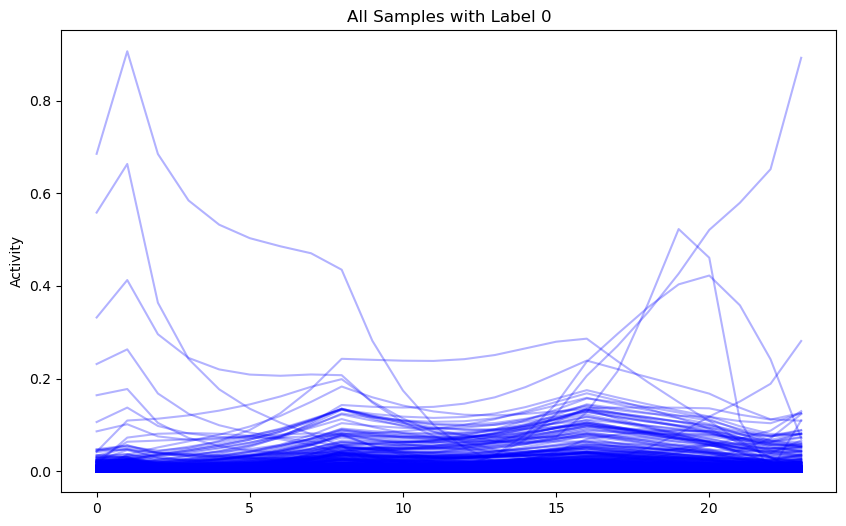

In [26]:
## PREPROCESSING ## 

# split features from labels
x_train,x_test,y_train,y_test = pp.load_data(infile,test_ratio)

# process train data
x_train,y_train = pp.apply_smote(x_train,y_train)
x_train = pp.preprocess(x_train)

# process test data
x_test = pp.preprocess(x_test)

# show train data
print(f"Training Data:")
pp.plot_all(label=1,x=x_train,y=y_train)
pp.plot_all(label=0,x=x_train,y=y_train)

# show test data
print(f"Test Data:")
pp.plot_all(label=1,x=x_test,y=y_test)
pp.plot_all(label=0,x=x_test,y=y_test)

In [27]:
## DATASETS AND LOADERS ##

class PacketVolumeDataset(Dataset):
    def __init__(self, x,y):
        # convert to tensors
        self.x = torch.tensor(x, dtype=torch.float32) # float features
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
            return self.x[i], self.y[i]
    
train_dataset = PacketVolumeDataset(x_train, y_train)
test_dataset = PacketVolumeDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [28]:
## MODEL ##

# init model ---------------------------------------------
class NeuralNetwork(nn.Module):
   def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(24, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

   def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
   
model = NeuralNetwork()

In [ ]:
## TRAINING ##

def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x).squeeze(1)
        loss = loss_fn(pred, y.float())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss_val, current = loss.item(), batch * batch_size + len(x)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x).squeeze(1)
            test_loss += loss_fn(pred, y.float()).item()
            probs = torch.sigmoid(pred)
            predicted = (probs > 0.3).long()
            correct += (predicted == y).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    print(f"Test:\n Accuracy: {100*accuracy:>0.1f}%, Avg loss: {test_loss:>8f}\n")

# training -----------------------------------------------

num_pos = (train_dataset.y == 1).sum()
num_neg = (train_dataset.y == 0).sum()
pos_weight = (num_neg / num_pos).float().clone().detach()
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

weight_decay_rate = 0.01 
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_rate)

for t in range(epochs):
   print(f"Epoch {t+1}\n-------------------------------")
   train_loop(train_loader, model, loss_fn, optimizer,batch_size)
   test_loop(test_loader, model, loss_fn)

print("Training complete.")

Epoch 1
-------------------------------
loss: 0.702558  [   32/16804]
loss: 0.683833  [ 3232/16804]
loss: 0.668020  [ 6432/16804]
loss: 0.647157  [ 9632/16804]
loss: 0.552544  [12832/16804]
loss: 0.520822  [16032/16804]
Test:
 Accuracy: 74.5%, Avg loss: 0.517956

Epoch 2
-------------------------------
loss: 0.532945  [   32/16804]
loss: 0.484791  [ 3232/16804]
loss: 0.520480  [ 6432/16804]
loss: 0.443215  [ 9632/16804]
loss: 0.420775  [12832/16804]
loss: 0.372453  [16032/16804]
Test:
 Accuracy: 78.2%, Avg loss: 0.412670

Epoch 3
-------------------------------
loss: 0.445776  [   32/16804]
loss: 0.516779  [ 3232/16804]
loss: 0.297366  [ 6432/16804]
loss: 0.250373  [ 9632/16804]
loss: 0.513330  [12832/16804]
loss: 0.366432  [16032/16804]
Test:
 Accuracy: 81.9%, Avg loss: 0.368281

Epoch 4
-------------------------------
loss: 0.262162  [   32/16804]
loss: 0.336960  [ 3232/16804]
loss: 0.330620  [ 6432/16804]
loss: 0.372116  [ 9632/16804]
loss: 0.238098  [12832/16804]
loss: 0.241234  [1

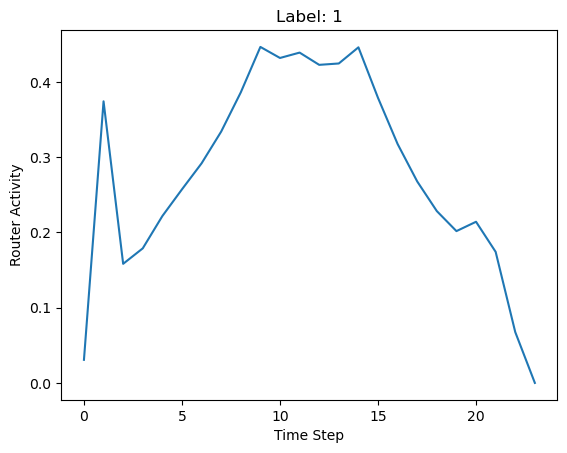

Expected Class: 1, Predicted class: 1


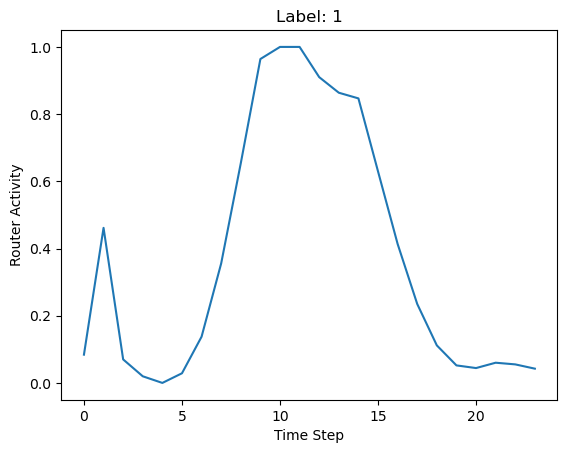

Expected Class: 1, Predicted class: 1


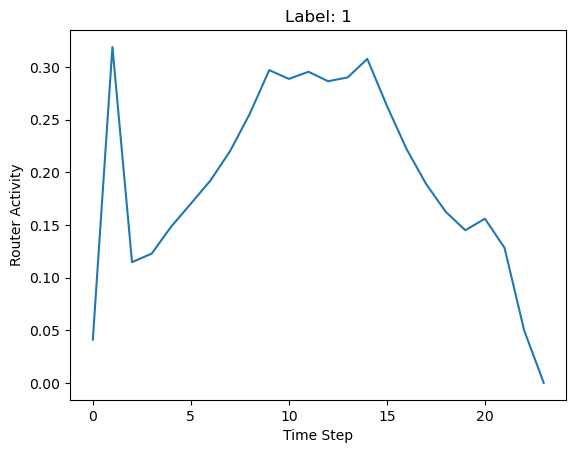

Expected Class: 1, Predicted class: 1


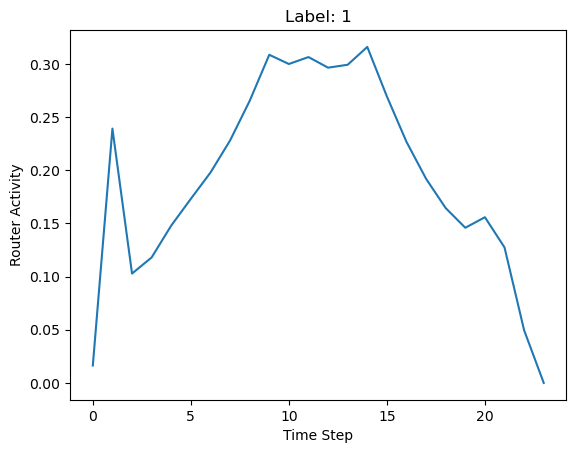

Expected Class: 1, Predicted class: 1


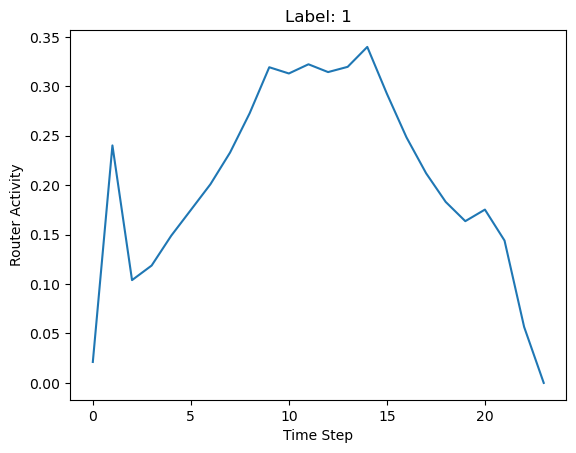

Expected Class: 1, Predicted class: 1


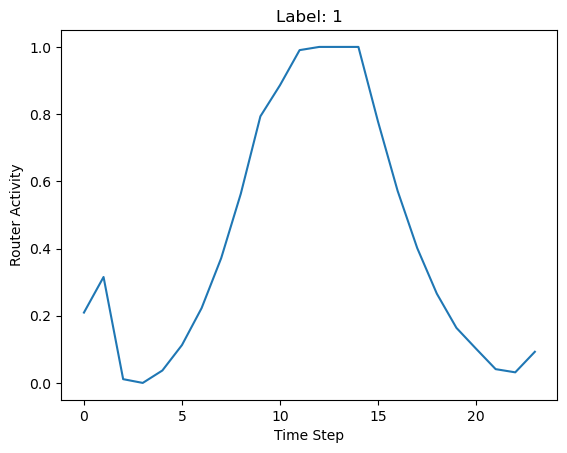

Expected Class: 1, Predicted class: 1


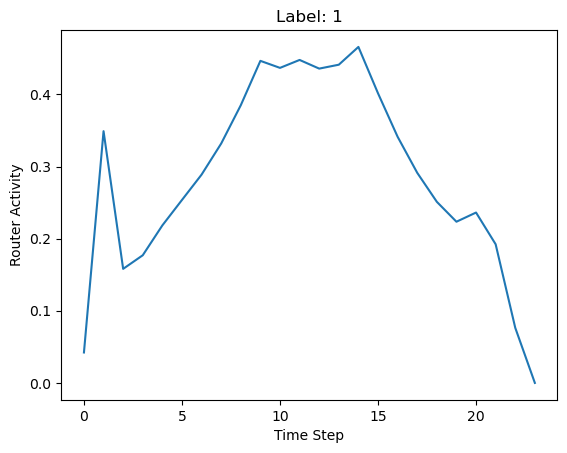

Expected Class: 1, Predicted class: 1


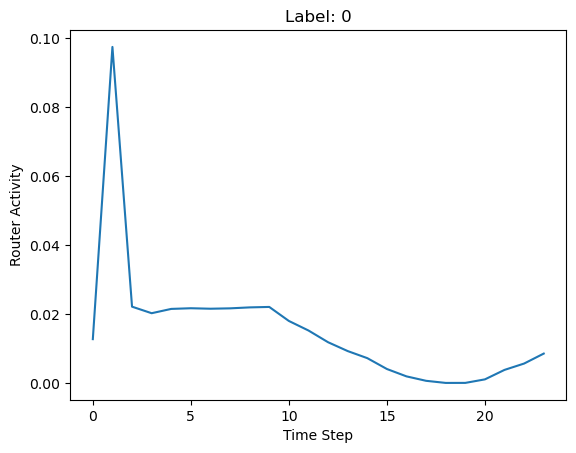

Expected Class: 0, Predicted class: 1


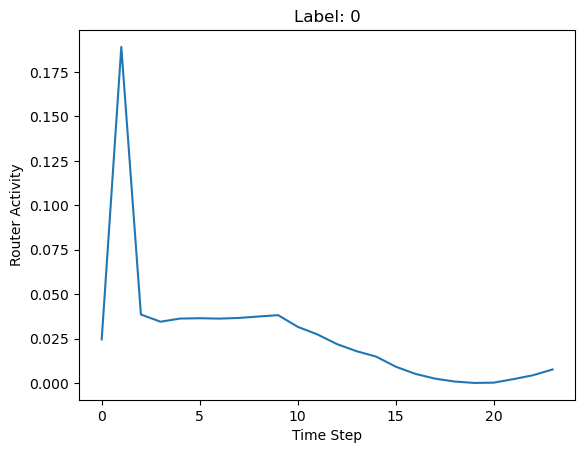

Expected Class: 0, Predicted class: 1


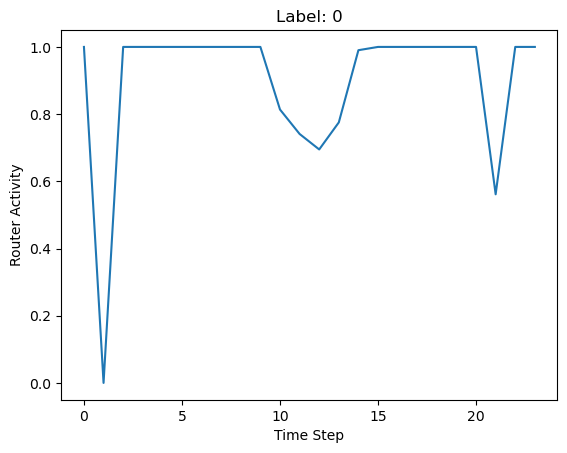

Expected Class: 0, Predicted class: 0


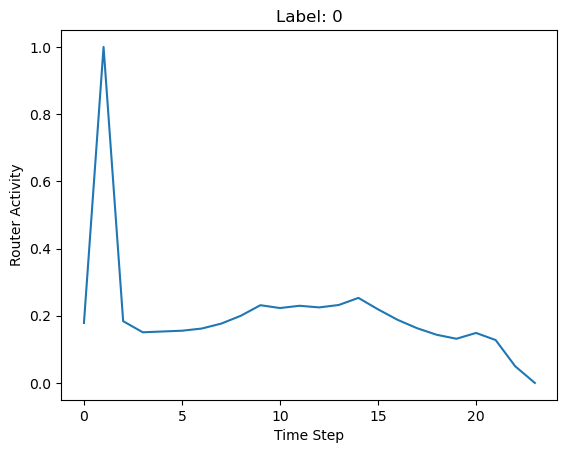

Expected Class: 0, Predicted class: 0


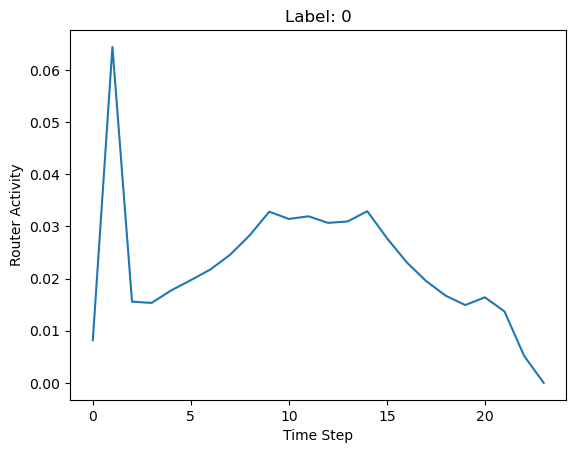

Expected Class: 0, Predicted class: 1


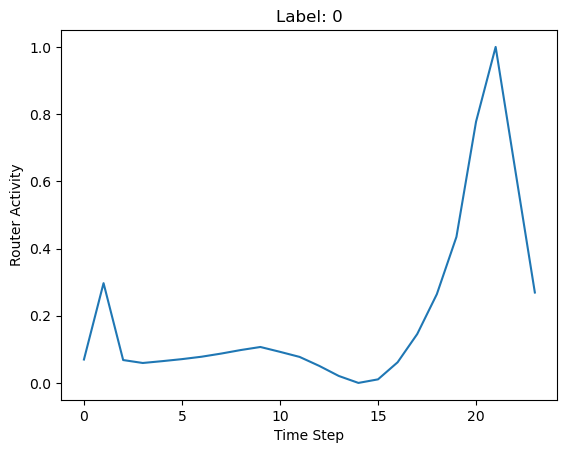

Expected Class: 0, Predicted class: 0


In [ ]:
## EVALUATING ##

# prepare sample data
fake_x = np.array([
    [1742574, 1309301, 854980, 845749, 1295418, 1046669, 1186644, 2444318, 9892404, 8900858, 9314173, 6559351, 7729406, 5566068, 5545285, 5168333, 3527205, 3830412, 1970841, 1561391, 2170332, 1019496, 1036777, 815651],
    [2846863, 2793026, 2690025, 2575829, 2766404, 2685467, 2749883, 3734520, 9210518, 16453809, 24299262, 14426791, 8111879, 12710529, 18608996, 12337080, 6077771, 4341472, 3037579, 2924926, 3125765, 2630030, 2651303, 2559211],
    [1286160, 1404790, 1018436, 1057457, 1081580, 1082207, 1048473, 1219347, 5687328, 5726489, 5344958, 6355086, 3944064, 4235216, 5420715, 4693978, 3157104, 1342014, 1186356, 1656127, 1045185, 929342, 1070158, 1031838],
    [2723543, 2521926, 2512656, 2495396, 2494409, 2530369, 2478070, 2623434, 7202134, 6910320, 7583243, 7339181, 4987902, 4420728, 6688413, 6299537, 3894323, 3555556, 2666046, 2781218, 2533726, 2467380, 2480560, 2485219],
    [661037, 513933, 513262, 524504, 497990, 562433, 539658, 1209198, 5164137, 5622412, 6356792, 2694582, 3613660, 7458493, 7301338, 4224568, 3153765, 950387, 506303, 541752, 566517, 503590, 533758, 553445],
    [2565792, 2752844, 2439341, 2499970, 2528265, 2515878, 2466449, 3106682, 9326992, 9484279, 13630762, 16695352, 13832456, 26091308, 14616971, 16219629, 8462756, 4051975, 2822737, 2572992, 2564315, 2518893, 2542810, 2511258],
    [3278669, 3030133, 3020349, 2943227, 3056234, 2956289, 2924279, 3191551, 7715183, 11500597, 10923847, 8359437, 5771335, 7937038, 10420633, 8662505, 6290151, 3117591, 3035830, 2930451, 2957221, 2925588, 3018833, 2969252],
    [2700895, 2809247, 2739390, 2814357, 3229762, 2765273, 2828796, 2853696, 2827387, 2896028, 2956544, 2787954, 2815954, 2844773, 2839134, 2861996, 2737680, 2787604, 2768300, 2743334, 2712500, 2753477, 2779897, 2752114],
    [1605712, 1779570, 1673335, 2093008, 2301180, 1765413, 1632180, 1755669, 2030415, 2427509, 2002657, 1841115, 2199058, 2010009, 1824218, 1996695, 1679604, 2080851, 1901068, 1469559, 1563360, 1712924, 1819248, 1726962],
    [9545025, 7253867, 7707477, 9395239, 8542984, 8416696, 12274906, 14630499, 14514380, 14803256, 14457000, 12146478, 13855758, 15123810, 16595177, 16389480, 14435881, 16582528, 18055188, 13440338, 11801108, 10525630, 13394189, 14410410],
    [5276968, 4299290, 5473130, 5109551, 4725551, 5609094, 4595799, 7416264, 6210408, 7294766, 4970169, 4515829, 6356154, 7612762, 8354584, 6934709, 6632063, 7599506, 6957316, 4752987, 5483198, 4666284, 4722537, 4493462],
    [1018622, 948948, 1052428, 1087420, 1030414, 921221, 1160806, 1380651, 1550899, 1447597, 1278008, 1408723, 1238199, 1089994, 1070918, 1116492, 1368248, 1962927, 1256414, 963262, 965265, 921791, 990433, 991475],
    [4276720, 4373242, 4217897, 4287024, 4300101, 4378906, 4460862, 4566716, 4431801, 4426951, 4489007, 4485787, 4710932, 4576262, 4638951, 4585624, 4778249, 4745055, 4400494, 4518881, 10569899, 25575688, 10190193, 4350815]
])
fake_y = np.array([1,1,1,1,1,1,1,0,0,0,0,0,0])
fake_x = pp.preprocess(fake_x)
fake_x = torch.tensor(fake_x, dtype=torch.float32)

# evaluate
model.eval()
with torch.no_grad():
    for i,sample in enumerate(fake_x):
        pp.plot_sample(x=sample,y=fake_y[i])
        logits = model(sample)
        prob = torch.sigmoid(logits)
        predicted_class = (prob > 0.3).long()
        print(f"Expected Class: {fake_y[i]}, Predicted class: {predicted_class.item()}")